In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Data

In [3]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"
basis = "6-311++g**"

data = Data()
data.include(data_path = "../../thesis/dataset/MethanT/", postfix = "MethanT", target=target)

# Make Block Masks

In [10]:
from SCFInitialGuess.construction.utilities import make_atom_pair_mask

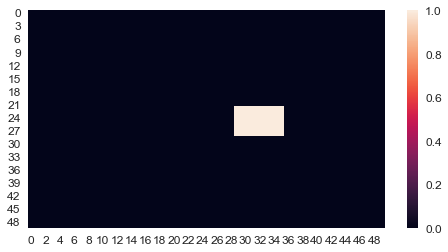

In [5]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
masks = make_atom_pair_mask(data.molecules[0][0], 1,2)

sns.heatmap(masks.astype("int"))

# Extract data 

In [90]:
from SCFInitialGuess.utilities.dataset import StaticDataset

In [ ]:
def extract_HOMO_block_dataset_pairs(descriptor, molecules, p_batch, species):  
    """Creates pairs of inputs and outputs for all all atoms of the element 
    species in the molecules to be used to set up a dataset for an NN 
    for a given descriptor and a target matrix p_batch. 
    The output are the (off-diagonal) homo-nuclear overlap blocks.
    """
    
    descriptor_values, blocks = [], []
    for p, mol in zip(p_batch, molecules):

        dim = mol.dim
        
        
        for i, atom_i in enumerate(mol.species):
            for j, atom_j in enumerate(mol.species):
                if i <= j:
                    continue
                    
                if atom_j == species and atom_i == species:
                    
                    #--- calculate symmetry vectors ---
                    descriptor_values.append(
                        list(
                            descriptor.calculate_atom_descriptor(
                                i, 
                                mol,
                                descriptor.number_of_descriptors
                            )
                        ) + list(
                            descriptor.calculate_atom_descriptor(
                                j, 
                                mol,
                                descriptor.number_of_descriptors
                            )
                        )
                    )
                    #---
                    
                    #--- extract blocks from target matrices ---
                    mask = make_atom_pair_mask(mol, i, j)
                    blocks.append(np.asarray(p).reshape(dim, dim).copy()[mask])
                    #---
                

    return descriptor_values, blocks

In [83]:
def extract_HETERO_block_dataset_pairs(descriptors, molecules, p_batch, species):  
    """Creates pairs of inputs and outputs for all all atoms of the element 
    species in the molecules to be used to set up a dataset for an NN 
    for a given descriptor and a target matrix p_batch. 
    The output are the (off-diagonal) hetero-nuclear overlap blocks.
    
    Args:
        descriptors <list> list of descriptors
        species <list<str>> list of species
    """
    
    descriptor_values, blocks = [], []
    for p, mol in zip(p_batch, molecules):

        dim = mol.dim
    
        
        for i, atom_i in enumerate(mol.species):
            for j, atom_j in enumerate(mol.species):
                
                # only check lower triu
                if i <= j:
                    continue
                    
                if (atom_j in species and atom_i in species and atom_i != atom_j):
                    
                    
                    #--- calculate symmetry vectors ---
                    # make sure descriptor[0] describes atom [1], regardless 
                    # of storage order of atoms in molecule
                    # by using aliases ii and jj
                    if atom_i == species[0]:
                        ii = i
                        jj = j
                    else:
                        ii = j
                        jj = i
                        
                    
                    descriptor_values.append(
                        list(
                            descriptors[0].calculate_atom_descriptor(
                                ii, 
                                mol,
                                descriptors[0].number_of_descriptors
                            )
                        ) + list(
                            descriptors[1].calculate_atom_descriptor(
                                jj, 
                                mol,
                                descriptors[1].number_of_descriptors
                            )
                        )
                    )
                    #---
                    
                    #--- extract blocks from target matrices ---
                    mask = make_atom_pair_mask(mol, i, j)
                    blocks.append(np.asarray(p).reshape(dim, dim).copy()[mask])
                    #---
                

    return descriptor_values, blocks

## assert result

In [78]:
class DescriptorMock(object):
    
    def __init__(self):
        self.number_of_descriptors = 1
        
    def calculate_atom_descriptor(self, index, mol, number_of_descriptors):
        return [index, mol.species[index]]

In [79]:
def make_target_matrix_mock(mol):
    dim = mol.dim
    
    T = np.zeros((dim, dim), dtype="object")
    
    for i, atom_i in enumerate(mol.species):
        for j, atom_j in enumerate(mol.species):
            mask = make_atom_pair_mask(mol, i, j)
            
            m = atom_i + str(i) + "-" + atom_j + str(j)
            
            if N_BASIS[mol.basis][atom_i] * N_BASIS[mol.basis][atom_j] :
                T[mask] = m
            else:
                T[mask] = np.array(
                    [
                        [
                            m
                        ] * N_BASIS[mol.basis][atom_j]
                    ] * N_BASIS[mol.basis][atom_i],
                    dtype="object"
                )
    return T

from SCFInitialGuess.utilities.dataset import Molecule
tmp = Molecule(
    ["H", "H", "O"],
    [[0,0,0], [1,0,0],[0,1,0]]
)
tmp.basis="sto-3g"

make_target_matrix_mock(tmp)

array([['H0-H0', 'H0-H1', 'H0-O2', 'H0-O2', 'H0-O2', 'H0-O2', 'H0-O2'],
       ['H1-H0', 'H1-H1', 'H1-O2', 'H1-O2', 'H1-O2', 'H1-O2', 'H1-O2'],
       ['O2-H0', 'O2-H1', 'O2-O2', 'O2-O2', 'O2-O2', 'O2-O2', 'O2-O2'],
       ['O2-H0', 'O2-H1', 'O2-O2', 'O2-O2', 'O2-O2', 'O2-O2', 'O2-O2'],
       ['O2-H0', 'O2-H1', 'O2-O2', 'O2-O2', 'O2-O2', 'O2-O2', 'O2-O2'],
       ['O2-H0', 'O2-H1', 'O2-O2', 'O2-O2', 'O2-O2', 'O2-O2', 'O2-O2'],
       ['O2-H0', 'O2-H1', 'O2-O2', 'O2-O2', 'O2-O2', 'O2-O2', 'O2-O2']],
      dtype=object)

In [80]:
G, T = extract_HOMO_block_dataset_pairs(
    DescriptorMock(), 
    [data.molecules[0][0]],
    [data.T[0][0]],
    "H"
)

In [85]:
G, T = extract_HETERO_block_dataset_pairs(
    [DescriptorMock(), DescriptorMock() ],
    [data.molecules[0][0]],
    [data.T[0][0]],
    ["H", "C"]
)
G

[[1, 'H', 0, 'C'], [2, 'H', 0, 'C'], [3, 'H', 0, 'C'], [4, 'H', 0, 'C']]

# Make Dataset 

## HOMO 

In [128]:
def make_block_dataset(descriptor, molecules, T, species, extractor_callback):
    """Makes a dataset with blocks and symmetry vectors from all molecules in 
    molecules. 

    descriptor <SCFInitialGuess.descriptors.high_level.*>: 
        a high level descriptor object.
    molecules <list<list<SCFInitialGuess.utilities.dataset.Molecule>>>:
        List with 3 elements (training data, validation and test). 
        Each are a list of molecules. 
    T <list<np.array>> or <list<list<list>>>: 
        List with training, validation and test data. 
        each is a numpy array. 
    species <string>: the element name of the desired species.
    """

    inputs_test, outputs_test = extractor_callback(
        descriptor,
        molecules[2], 
        T[2],
        species
    )
    
    inputs_validation, outputs_validation = extractor_callback(
        descriptor,
        molecules[1], 
        T[1],
        species
    )

    inputs_train, outputs_train = extractor_callback(
        descriptor,
        molecules[0], 
        T[0],
        species
    )
    
    print(
        np.array(inputs_train).shape, 
        np.array(inputs_validation).shape, 
        np.array(inputs_test).shape
    )
    
    #_, mu, std = StaticDataset.normalize(inputs_train + inputs_validation + inputs_test)
    _, mu, std = normalize(inputs_train + inputs_validation + inputs_test)
    
    dataset = StaticDataset(
        train=(
            StaticDataset.normalize(inputs_train, mean=mu, std=std)[0], 
            np.asarray(outputs_train)
        ),
        validation=(
            StaticDataset.normalize(inputs_validation, mean=mu, std=std)[0], 
            np.asarray(outputs_validation)
        ),
        test=(
            StaticDataset.normalize(inputs_test, mean=mu, std=std)[0], 
            np.asarray(outputs_test)
        ),
        mu=mu,
        std=std
    )
    
    return dataset

In [129]:
#def make_block_dataset(descriptor, molecules, T, species, extractor_callback):

def normalize(x, std_tolerance=1e-20, mean=None, std=None):
    """Will trans form a dataset with elements x_ij, where j is the index
    that labels the example and i the index that labels to which input
    the value corresponds, in the following way:

        x_ij = x_ij - mean(x_ij, j) / var(x_ij, j)

    where mean(..., j) and var(..., j) denote operation w.r.t j (i fixed.)
    """
    
    print(np.array(x).shape)
    
    if mean is None or std is None:
        mean = np.average(x, 0)
        std = np.std(x, 0)

    # handle dvision by zero if std == 0
    return (
        (x - mean) / np.where(np.abs(std) < std_tolerance, 1, std),
        mean,
        std
    )

In [131]:

make_block_dataset(
    DescriptorMock(), 
    data.molecules,
    data.T, 
    "H", 
    extract_HOMO_block_dataset_pairs
)

(3840, 4) (960, 4) (1206, 4)
(6006, 4)


TypeError: cannot perform reduce with flexible type